In [2]:
#CODE COPIED FROM LCS2-IIITD DABERTA-EMNLP-2022 Repository
import math
import copy
from typing import Optional, List
import torch
from torch import nn

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, num_layers, num_heads, dim_feedforward=2048):
        super(TransformerEncoder, self).__init__()
        self.d_model = d_model
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.encoder = _TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos_encoder = PositionalEncoding(d_model, dropout=0.1)

    def forward(self, inputs: torch.Tensor, lens: Optional[List[int]] = None):
        if lens is not None:
            max_len = max(lens)

            mask = [([False] * l + [True] * (max_len - l)) for l in lens]
            mask = torch.tensor(mask).to(device=inputs.device)
        else:
            mask = None

        inputs = inputs.permute(1, 0, 2)

        inputs = inputs * math.sqrt(self.d_model)
        inputs = self.pos_encoder(inputs)

        outputs = self.encoder(src=inputs, src_key_padding_mask=mask) # (seq_len, bs, dim)

        return [o.permute(1, 0, 2) for o in outputs]


    
def padTensor(t: torch.Tensor, targetLen: int) -> torch.Tensor:
    oriLen, dim = t.size()
    return torch.cat((t, torch.zeros(targetLen - oriLen, dim).to(t.device)), dim=0)



def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])



class _TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers, norm=None):
        super(_TransformerEncoder, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src: torch.Tensor, mask: Optional[torch.Tensor] = None, src_key_padding_mask: Optional[torch.Tensor] = None) -> torch.Tensor:
        outputs = [src]

        for mod in self.layers:
            output = mod(outputs[-1], src_mask=mask, src_key_padding_mask=src_key_padding_mask)
            outputs.append(output)

        if self.norm is not None:
            outputs[-1] = self.norm(outputs[-1])

        return outputs[1:]

    
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [3]:
!pip install pytorch-crf

In [4]:
# Code for Description Aware Roberta (DABERTa)
# File: daberta.py
#CODE COPIED FROM LCS2-IIITD DABERTA-EMNLP-2022 Repository
# ----------------------------------------------------- IMPORTS -----------------------------------------------------

import os
import numpy as np
import pandas as pd
import json
import warnings
import logging
import gc
import random
import math
import re
import ast
import wandb
from tqdm import tqdm
from typing import Optional
from sklearn.metrics import f1_score, precision_score, recall_score

from datetime import datetime

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn

from torchcrf import CRF

from torch.utils.data import (
    DataLoader, 
    TensorDataset
)

from torch.cuda.amp import (
    autocast, 
    GradScaler
)

from transformers.modeling_utils import (
    PreTrainedModel, 
    unwrap_model
)

from transformers import (
    RobertaTokenizerFast,
    AdamW
)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")
    
    
SCALER = GradScaler()


# ----------------------------------------------------- CONFIGS -----------------------------------------------------

INPUT_PATH = 'dataset/'
OUTPUT_PATH = 'models/'

TWEET_MAX_LEN = 185
DEFINITION_MAX_LEN = 25

LABEL_ALL_TOKENS = True
PAD_TO_MAX_LENGTH = True
TRUNCATION = True

BATCH_SIZE = 16
MAX_EPOCHS = 5

BASE_LEARNING_RATE = 4e-5

CLAIM_DEFINITIONS_LEN = 12


def set_random_seed(seed: int):
    """
    Helper function to seed experiment for reproducibility.
    If -1 is provided as seed, experiment uses random seed from 0~9999
    Args:
        seed (int): integer to be used as seed, use -1 to randomly seed experiment
    """
    print("Seed: {}".format(seed))

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
SEED = 0
set_random_seed(SEED)

# ----------------------------------------------------- MODEL ARCHITECTURE -----------------------------------------------------

import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from typing import Optional, Tuple

from transformers.models.roberta.configuration_roberta import RobertaConfig

from transformers.models.roberta.modeling_roberta import (
    RobertaPreTrainedModel,
    RobertaLayer,
    RobertaEmbeddings,
    RobertaPooler
)

from transformers.modeling_outputs import (
    BaseModelOutputWithPastAndCrossAttentions,
    BaseModelOutputWithPoolingAndCrossAttentions,
    TokenClassifierOutput
)


# ----------------------------------------------------- IGM MODULE -----------------------------------------------------

class IGM(nn.Module):

    def __init__(self,
                 dim: int):
        super(IGM, self).__init__()

        # Conflict Gate
        self.w_c1 = nn.Linear(dim, dim, bias=False)
        self.w_c2 = nn.Linear(dim, dim, bias=False)
        self.b_mu_c = nn.Parameter(torch.rand(dim))
        torch.nn.init.uniform_(self.b_mu_c, a=-math.sqrt(dim), b=math.sqrt(dim))

        self.w_c3 = nn.Linear(dim, dim, bias=False)
        self.w_c4 = nn.Linear(dim, dim, bias=False)
        self.b_c = nn.Parameter(torch.rand(dim))
        torch.nn.init.uniform_(self.b_c, a=-math.sqrt(dim), b=math.sqrt(dim))

        # Refine Gate
        self.w_r1 = nn.Linear(dim, dim, bias=False)
        self.w_r2 = nn.Linear(dim, dim, bias=False)
        self.b_mu_r = nn.Parameter(torch.rand(dim))
        torch.nn.init.uniform_(self.b_mu_r, a=-math.sqrt(dim), b=math.sqrt(dim))

        self.w_r3 = nn.Linear(dim, dim, bias=False)
        self.w_r4 = nn.Linear(dim, dim, bias=False)
        self.b_r = nn.Parameter(torch.rand(dim))
        torch.nn.init.uniform_(self.b_r, a=-math.sqrt(dim), b=math.sqrt(dim))

        # Adaptive Gate
        self.w_a =  nn.Linear(dim, dim, bias=False)
        self.b_a = nn.Parameter(torch.rand(dim))
        torch.nn.init.uniform_(self.b_a, a=-math.sqrt(dim), b=math.sqrt(dim))




    def forward(self, 
                input1: torch.tensor,
                input2: torch.tensor):
        # MAx Pooling
        pooled_input1, _ = torch.max(input1, dim=1)        
        pooled_input2, _ = torch.max(input2, dim=1)
        
        # Conflict Gate
        mu_c = F.sigmoid(self.w_c1(pooled_input1) + self.w_c2(pooled_input2) + self.b_mu_c)
        conflict = F.tanh(self.w_c3(torch.mul(mu_c, pooled_input1)) + self.w_c4(torch.mul((1 - mu_c), pooled_input2)) + self.b_c)
        
        # Refine Gate
        mu_r = F.sigmoid(self.w_r1(pooled_input1) + self.w_r2(pooled_input2) + self.b_mu_r)
        refine = F.tanh(self.w_r3(torch.mul(mu_r, pooled_input1)) + self.w_r4(torch.mul(mu_r, pooled_input2)) + self.b_r)
        
        # Adaptive Gate
        adapt = refine + torch.mul((1 - mu_r), conflict)
        interact = F.tanh(self.w_a(adapt) + self.b_a)   
        interact = torch.unsqueeze(interact, 1).repeat(1, input1.shape[1], 1)        
        output = torch.mul(interact, input1)
        return output
    
# ----------------------------------------------------- CoDA MODULE -----------------------------------------------------

class CoDA(nn.Module):

    def __init__(self,
                 dim_model: int,
                 multi_head: Optional[bool]=False,
                 num_heads: Optional[int]=1,
                 alpha: Optional[float]=1.0,
                 beta: Optional[float]=1.0,
                 scaling: Optional[bool]=False,
                 centering_E: Optional[bool]=False,
                 centering_N: Optional[bool]=False):
        super(CoDA, self).__init__()
        
        assert (
            dim_model % num_heads == 0
        ), f"dim_model must be divisible by num_heads (got `embed_dim`: {dim_model} and `num_heads`: {num_heads})."

        self.dim_model = dim_model
        self.multi_head = multi_head
        self.num_heads = num_heads
        
        if self.multi_head and self.num_heads > 1:
            self.head_dim = self.dim_model // self.num_heads
            self.query_transform = nn.Linear(self.dim_model, self.num_heads * self.head_dim, bias=False)
            self.key_transform = nn.Linear(self.dim_model, self.num_heads * self.head_dim, bias=False)
            self.value_transform = nn.Linear(self.dim_model, self.num_heads * self.head_dim, bias=False)
        
        else:
            self.query_transform = nn.Linear(self.dim_model, self.dim_model, bias=False)
            self.key_transform = nn.Linear(self.dim_model, self.dim_model, bias=False)
            self.value_transform = nn.Linear(self.dim_model, self.dim_model, bias=False)

        self.alpha = alpha
        self.beta = beta
        self.scaling = scaling
        self.centering_E = centering_E
        self.centering_N = centering_N
        
        self.fc = nn.Linear(self.dim_model, self.dim_model)
        self.dropout = nn.Dropout(0.2)
        self.layer_norm = nn.LayerNorm(self.dim_model)
      



    
    def coda_attention(self,
                       q: torch.Tensor, 
                       k: torch.Tensor,
                       v: torch.Tensor):  
        # KEY AND VALUE ARE FROM THE DIFFERENT MODALITY
        # QUERY REMAINS THE SAME
        if self.multi_head and self.num_heads > 1:
            E = torch.mul(self.alpha, torch.matmul(q, k.transpose(-2, -1)))
            if self.centering_E:
                E = E - torch.mean(E)

            N = None
            q = q.permute(1, 0, 2, 3)
            k = k.permute(1, 0, 2, 3)
            for head_q, head_k in list(zip(q, k)):
                head_N = torch.cdist(head_q, head_k, p=1)

                head_N = head_N.unsqueeze(0)
                if N is None:
                    N = head_N
                else:
                    N = torch.cat([N, head_N], dim=0)

            q = q.permute(1, 0, 2, 3)
            k = k.permute(1, 0, 2, 3)
            N = N.permute(1, 0, 2, 3)
            
            if self.centering_N:
                N = N - torch.mean(N)

            if self.scaling:
                E  = E / math.sqrt(k.shape[-1])
                N = N / math.sqrt(k.shape[-1])

            if self.centering_N:
                coda = torch.mul(F.tanh(E), F.sigmoid(N))
            else:
                coda = torch.mul(F.tanh(E), F.sigmoid(N))
            output = torch.matmul(coda, v)
            return output
        
        else:
            E = torch.mul(self.alpha, torch.matmul(q, k.transpose(-2, -1)))
            if self.centering_E:
                E = E - torch.mean(E)

            N = torch.mul(-self.beta, torch.cdist(q, k, p=1))
            if self.centering_N:
                N = N - torch.mean(N)

            if self.scaling:
                E  = E / math.sqrt(k.shape[-1])
                N = N / math.sqrt(k.shape[-1])

            if self.centering_N:
                coda = torch.mul(F.tanh(E), F.sigmoid(N))
            else:
                coda = torch.mul(F.tanh(E), F.sigmoid(N))
            output = torch.matmul(coda, v)
            return output

    

    def forward(self, 
                query: torch.Tensor, 
                key: torch.Tensor,
                value: torch.Tensor):
        
        batch_size = query.shape[0]
        residual = query
        
        query = self.query_transform(query)
        key = self.key_transform(key)
        value = self.value_transform(value)

        if self.multi_head and self.num_heads > 1:
            query = query.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
            key = key.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
            value = value.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
            coda_output = self.coda_attention(q=query,
                                              k=key,
                                              v=value)
            coda_output = coda_output.transpose(1, 2).contiguous().view(batch_size, -1, self.dim_model)
        else:
            coda_output = self.coda_attention(q=query,
                                              k=key,
                                              v=value)
        coda_output = self.fc(self.dropout(coda_output))
        coda_output = self.layer_norm(coda_output + residual)
        return coda_output
    
    
# ----------------------------------------------------- DESCNET MODULE -----------------------------------------------------

class DescNet(nn.Module):

    def __init__(self, 
                 dim_model: int,
                 multi_head: Optional[bool]=False,
                 num_heads: Optional[int]=1,
                 alpha: Optional[float]=1.0,
                 beta: Optional[float]=1.0,
                 scaling: Optional[bool]=False,
                 centering_E: Optional[bool]=False,
                 centering_N: Optional[bool]=False):
        super(DescNet, self).__init__()
        self.def_encoder = TransformerEncoder(d_model=dim_model, 
                                              num_layers=2,
                                              num_heads=4, 
                                              dim_feedforward=dim_model)
        self.attention_layer = CoDA(dim_model=dim_model,
                                    multi_head=multi_head,
                                    num_heads=num_heads,
                                    alpha=alpha,
                                    beta=beta,
                                    scaling=scaling,
                                    centering_E=centering_E,
                                    centering_N=centering_N)
        self.igm_layer = IGM(dim=dim_model)
        self.fc = nn.Linear(CLAIM_DEFINITIONS_LEN * dim_model, dim_model)
        self.dropout_1 = nn.Dropout(0.2)
        self.dropout_2 = nn.Dropout(0.2)
        
        



    def forward(self, 
                encoder_output: torch.tensor,
                definition_inputs: torch.tensor):   
        defnet_out = None
        definition_inputs = definition_inputs.permute(1, 0, 2, 3)
        for definition_input in definition_inputs:
            definition_input = self.def_encoder(definition_input)[-1]
            attention_out = self.attention_layer(query=encoder_output, 
                                                 key=definition_input,
                                                 value=definition_input)
            if defnet_out is None:
                defnet_out = attention_out
            else:
                defnet_out = torch.cat([defnet_out, attention_out], dim=-1)

        output = self.fc(defnet_out)
        output = self.dropout_1(output)
        output = self.igm_layer(encoder_output, output)
        output = self.dropout_2(output)
        return output   
    
    
# ----------------------------------------------------- ROBERTA ENCODER -----------------------------------------------------

class CustomRobertaEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([RobertaLayer(config) for _ in range(config.num_hidden_layers)])
        self.gradient_checkpointing = False
        
        # ==================================== Modifications ==================================== #
        self.fusion_at_layer = 11
        self.desc_net = DescNet(dim_model=config.hidden_size,
                                multi_head=False,
                                num_heads=1,
                                alpha=1.0,
                                beta=1.0,
                                scaling=True,
                                centering_E=False,
                                centering_N=False)
        # ======================================================================================= #
        
        
        

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        definition_inputs=None,      # New addition of definition_inputs
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None
            past_key_value = past_key_values[i] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:

                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, past_key_value, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask,
                    layer_head_mask,
                    encoder_hidden_states,
                    encoder_attention_mask,
                    past_key_value,
                    output_attentions,
                )

            hidden_states = layer_outputs[0]
            
            # ==================================== Modifications ==================================== #
            if i == self.fusion_at_layer:
                hidden_states = self.desc_net(encoder_output=hidden_states,
                                              definition_inputs=definition_inputs)
            # ======================================================================================= #
            
            if use_cache:
                next_decoder_cache += (layer_outputs[-1],)
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )


# Copied from transformers.models.bert.modeling_bert.BertPooler
class RobertaPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output
    
# ----------------------------------------------------- ROBERTA MODEL -----------------------------------------------------

class CustomRobertaModel(RobertaPreTrainedModel):
    """

    The model can behave as an encoder (with only self-attention) as well as a decoder, in which case a layer of
    cross-attention is added between the self-attention layers, following the architecture described in `Attention is
    all you need`_ by Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz
    Kaiser and Illia Polosukhin.

    To behave as an decoder the model needs to be initialized with the :obj:`is_decoder` argument of the configuration
    set to :obj:`True`. To be used in a Seq2Seq model, the model needs to initialized with both :obj:`is_decoder`
    argument and :obj:`add_cross_attention` set to :obj:`True`; an :obj:`encoder_hidden_states` is then expected as an
    input to the forward pass.

    .. _`Attention is all you need`: https://arxiv.org/abs/1706.03762

    """

    _keys_to_ignore_on_load_missing = [r"position_ids"]

    # Copied from transformers.models.bert.modeling_bert.BertModel.__init__ with Bert->Roberta
    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = RobertaEmbeddings(config)
        self.encoder = CustomRobertaEncoder(config)

        self.pooler = RobertaPooler(config) if add_pooling_layer else None

        self.init_weights()
        

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)


    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        definition_inputs=None,      # New addition of definition_inputs
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        encoder_hidden_states  (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in ``[0, 1]``:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (:obj:`tuple(tuple(torch.FloatTensor))` of length :obj:`config.n_layers` with each tuple having 4 tensors of shape :obj:`(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.

            If :obj:`past_key_values` are used, the user can optionally input only the last :obj:`decoder_input_ids`
            (those that don't have their past key value states given to this model) of shape :obj:`(batch_size, 1)`
            instead of all :obj:`decoder_input_ids` of shape :obj:`(batch_size, sequence_length)`.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        batch_size, seq_length = input_shape
        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

        if token_type_ids is None:
            if hasattr(self.embeddings, "token_type_ids"):
                buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape, device)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        embedding_output = self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length,
        )
        

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            definition_inputs=definition_inputs,      # New addition of definition_inputs
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )
    
    
# ------------------------------------------------- ROBERTA FOR TOKEN CLASSIFICATION -------------------------------------------------

class CustomRobertaForTokenClassification(RobertaPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = CustomRobertaModel(config, add_pooling_layer=False)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()
        



    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        definition_inputs=None,      # New addition of definition_inputs
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            definition_inputs=definition_inputs,      # New addition of definition_inputs
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # Only keep active parts of the loss
            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
    
# ----------------------------------------------------- MODEL SETUP -----------------------------------------------------

class CustomRobertaCRF(nn.Module):
    '''
        Token BERT with (optional) Conditional Random Fileds (CRF)
    '''

    def __init__(self, 
                 num_labels,
                 model_name, 
                 output_hidden_states=False,
                 output_attentions=False, 
                 batch_first=True,
                 use_crf=True):
        
        super(CustomRobertaCRF, self).__init__()
        self.num_labels = num_labels
        self.batch_first = batch_first
        self.use_crf = use_crf
        self.base_model = CustomRobertaForTokenClassification.from_pretrained(
            model_name,
            num_labels=self.num_labels,
            output_hidden_states=output_hidden_states,
            output_attentions=output_attentions
        )
        if self.use_crf:
            self.crf = CRF(self.num_labels, batch_first=self.batch_first)

            
            
            
    def forward(self,
                input_ids,
                attention_mask,
                definition_inputs,      # New addition of definition_inputs
                labels=None):
        
        outputs = self.base_model.roberta(
            input_ids,
            attention_mask=attention_mask,
            definition_inputs=definition_inputs,      # New addition of definition_inputs
        )
        sequence_output = outputs[0]
        sequence_output = self.base_model.dropout(sequence_output) 
        logits = self.base_model.classifier(sequence_output)

        if self.use_crf:
            if labels is not None: # training
                loss = -self.crf(logits, labels, attention_mask.byte(), reduction='mean')
                preds = self.crf.decode(logits, attention_mask.byte())
                return loss, preds
            else: # inference
                return self.crf.decode(logits, attention_mask.byte())
        else:
            if labels is not None: # training
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(
                    logits.view(-1, self.num_labels),
                    labels.view(-1)
                )
                return loss
            else: # inference
                return torch.argmax(logits, dim=2)
            


Using GPU
Seed: 0


In [5]:
            
# ----------------------------------------------------- DATA UTILS -----------------------------------------------------
           
def getData(tokenizer, token_data, span_start, span_end):
    
    mapList = []
    tokenizedList = []
    maxLength = 200
    for datapoint in token_data:
        
        curMap = {}
        curTokenList = [tokenizer.convert_tokens_to_ids(tokenizer.cls_token)]
        for i in range(len(datapoint)):
            curMap[i] = []
            curTk = tokenizer.tokenize(datapoint[i])  
            #iterate over subwords 
            for tk in curTk:
                curMap[i].append(len(curTokenList))
                curTokenList.append(tokenizer.convert_tokens_to_ids(tk))
        curTokenList.append(tokenizer.convert_tokens_to_ids(tokenizer.sep_token))

        mapList.append(curMap)
        tokenizedList.append(curTokenList)
    
    #padding 
    attn_mask = np.zeros((len(token_data), maxLength))
    for i in range(len(tokenizedList)):
        for j in range(len(tokenizedList[i])):
            attn_mask[i][j] = 1
        while (len(tokenizedList[i]) < maxLength):
            tokenizedList[i].append(tokenizer.convert_tokens_to_ids(tokenizer.pad_token))

    #y value - [pad - 0, O - 1, I - 2, B - 3]
    y_val = np.ones((len(token_data), maxLength))
    for dp in range(len(span_start)):
        #overwrite points in ranges 'I'
        for i in range(len(span_start[dp])):
            for idx in range(span_start[dp][i], span_end[dp][i]+1):
                for k in mapList[dp][idx]:           
                    if (idx == span_start[dp][i]):
                        y_val[dp][k] = 3 #B
                    else:
                        y_val[dp][k] = 2 #I
        
    # mark the padded sequence as 'Not part of tweet': 3
    for i in range(len(token_data)):
        for j in range(maxLength):
            if (attn_mask[i][j] == 0):
                
                if (y_val[i][j] != 1):
                    print("Assertion_Failed")

                y_val[i][j] = 0

    return np.array(tokenizedList), attn_mask, y_val, mapList




def getIOData(fileName: str,
              definition_path: str,
              tokenizer):
    data = pd.read_csv(fileName)
    token_data, span_start, span_end = [], [], []
    cnt_nonClaims = 0
    for i in range(len(data)):
        if (data['claim_label'][i] == 1):
            token_data.append(ast.literal_eval((data['tokens'][i])))
            span_start.append(json.loads(data['span_start_index'][i]))
            span_end.append(json.loads(data['span_end_index'][i]))
        elif (data['claim_label'][i] == 0):
            cnt_nonClaims += 1
    tokenizedList, attn_mask, y_val, mapList = getData(tokenizer, token_data, span_start, span_end)
    model_inputs = {}
    model_inputs['input_ids'] = torch.tensor([i for i in tokenizedList], dtype=torch.long, device=DEVICE)
    model_inputs['attention_mask'] = torch.tensor([i for i in attn_mask], dtype=torch.long, device=DEVICE)
    model_inputs['labels'] = torch.tensor([i for i in y_val], dtype=torch.long, device=DEVICE)
    model_inputs['definition_inputs'] = torch.unsqueeze(pd.read_pickle(definition_path), 0).repeat(model_inputs['input_ids'].shape[0], 1, 1, 1)

    return model_inputs, mapList



def set_up_data_loader(text_path: str,
                       definition_path: str,
                       tokenizer,
                       lowercase_utterances: bool=False,
                       unfolded_dialogue: bool=False):
    dataset, tweet_word_ids = getIOData(fileName=text_path, 
                                        definition_path=definition_path,
                                        tokenizer=tokenizer)
    dataset = TensorDataset(dataset['input_ids'],
                            dataset['attention_mask'], 
                            dataset['definition_inputs'],
                            dataset['labels'])
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    ), tweet_word_ids    

In [6]:
# ----------------------------------------------------- METRIC UTILS -----------------------------------------------------

def getPredictions(y_val, preds, mapList):
    
    groundTruth = []
    predictedIdx = []
    bioGround = []
    bioPreds = []
    #if any a subword lies in span - the word is in span
    for dp in range(len(y_val)):
        curG = []
        curP = []
        curBIO = []
        curBIOG = []
        for i in mapList[dp].keys():
            containsI_ground = False
            containsI_pred = False
            isBegin = False
            isBeginG = False
            for k in mapList[dp][i]:
                if (y_val[dp][k] >= 2):  #subword is I or B
                    containsI_ground = True
                    if (y_val[dp][k] == 3):
                        isBeginG = True
                if (preds[dp][k] >= 2):  #subword is I or B
                    containsI_pred = True
                    if (y_val[dp][k] == 3):
                        isBegin = True
                break           # We only consider first subword label in deciding the word level label

            if (containsI_ground):
                curG.append(i)
                if (isBeginG):
                    curBIOG.append(1) #B
                else:
                    curBIOG.append(2) #I
            else:
                curBIOG.append(0) #O
            if (containsI_pred):
                if (isBegin):
                    curBIO.append(1) #B
                else:
                    curBIO.append(2) #I
                curP.append(i)
            else:
                curBIO.append(0) #O

        groundTruth.append(curG)
        predictedIdx.append(curP)
        bioPreds.append(curBIO)
        bioGround.append(curBIOG)
    return groundTruth, predictedIdx, bioGround, bioPreds



def get_token_list(labels):
    return [i for i in range(len(labels)) if labels[i]!=0]


def f1(predictions_bio, gold_bio):
    gold = get_token_list(gold_bio)
    predictions = get_token_list(predictions_bio)
    
    if len(gold) == 0:
        return 1 if len(predictions)==0 else 0
    nom = 2*len(set(predictions).intersection(set(gold)))
    denom = len(set(predictions))+len(set(gold))
    return nom/denom


def get_dice(ground, preds):
    tot = 0
    for i in range(len(preds)):
        tot += f1(ground[i], preds[i])
    return tot/len(preds)

def get_hard_f1(ground, preds):
    return np.mean([f1_score(l, p, average='macro', zero_division=0) for l, p in list(zip(ground, preds))])


def get_hard_recall(ground, preds):
    return np.mean([recall_score(l, p, average='macro', zero_division=0) for l, p in list(zip(ground, preds))])


def get_hard_precision(ground, preds):
    return np.mean([precision_score(l, p, average='macro', zero_division=0) for l, p in list(zip(ground, preds))])


def get_hard_recall_classwise(ground, preds):
    return np.mean([recall_score(l, p, labels=[0,1,2], average=None, zero_division=0)  for l, p in list(zip(ground, preds))], axis=0)


def get_hard_precision_classwise(ground, preds):
    return np.mean([precision_score(l, p, labels=[0,1,2], average=None, zero_division=0) for l, p in list(zip(ground, preds))], axis=0)


def get_hard_f1_classwise(ground, preds):
    return np.mean([f1_score(l, p, labels=[0,1,2], average=None, zero_division=0) for l, p in list(zip(ground, preds))], axis=0)


def compute_metrics(ground, 
                    preds):
    # f1 score for every tag
    hard_f1_classwise=[round(v, 4) for v in get_hard_f1_classwise(ground, preds)]
    f1_B = hard_f1_classwise[1]
    f1_I = hard_f1_classwise[2]
    f1_O = hard_f1_classwise[0]    

    # precision
    hard_precision_classwise=[round(v, 4) for v in get_hard_precision_classwise(ground, preds)]
    precision_B = hard_precision_classwise[1]
    precision_I = hard_precision_classwise[2]
    precision_O = hard_precision_classwise[0] 

    # recall
    hard_recall_classwise=[round(v, 4) for v in get_hard_recall_classwise(ground, preds)]
    recall_B = hard_recall_classwise[1]
    recall_I = hard_recall_classwise[2]
    recall_O = hard_recall_classwise[0] 

    return {
        "F1": round(get_hard_f1(ground, preds), 4),
        "Precision": round(get_hard_precision(ground, preds), 4),
        "Recall": round(get_hard_recall(ground, preds), 4),
        "F1_B": round(f1_B, 4),
        "F1_I": round(f1_I, 4),
        "F1_O": round(f1_O, 4),
        "Precision_B": round(precision_B, 4),
        "Precision_I": round(precision_I, 4),
        "Precision_O": round(precision_O, 4),
        "Recall_B": round(recall_B, 4),
        "Recall_I": round(recall_I, 4),
        "Recall_O": round(recall_O, 4),
        "DSC": round(get_dice(ground, preds), 4)
    }

In [7]:
# ----------------------------------------------------- TRAINING UTILS -----------------------------------------------------

def train_epoch(model,
                data_loader,
                optimizer):
    model.train()
    epoch_train_loss = 0.0
    for step, batch in enumerate(tqdm(data_loader, desc="Training Iteration")):
        optimizer.zero_grad()
        
        with autocast():
            batch = tuple(t.to(DEVICE) for t in batch)
            input_ids, attention_mask, definition_inputs, labels = batch

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            definition_inputs=definition_inputs,
                            labels=labels)
            loss = outputs[0]
            epoch_train_loss += loss.item()
        
        SCALER.scale(loss).backward()
        SCALER.step(optimizer)
        SCALER.update()
    
    del batch
    del input_ids
    del attention_mask
    del definition_inputs
    del labels
    del outputs
    del loss
    gc.collect()
    torch.cuda.empty_cache()
    
    return round(epoch_train_loss/ step, 4)




def val_epoch(model,
              tokenizer,
              data_loader):
    model.eval()
    
    epoch_val_loss = 0.0
    y_true = []
    y_pred = []
    
    for step, batch in enumerate(tqdm(data_loader, desc="Validation Loss Iteration")):  
        
        with torch.no_grad():
            
            with autocast():
                
                batch = tuple(t.to(DEVICE) for t in batch)
                batch_input_ids, batch_attention_mask, definition_inputs, batch_labels = batch
                
                outputs = model(input_ids=batch_input_ids,
                                attention_mask=batch_attention_mask,
                                definition_inputs=definition_inputs,
                                labels=batch_labels)
                loss = outputs[0]
                epoch_val_loss += loss.item()  
                batch_tags = outputs[1]
                
            batch_labels = [labels.cpu().tolist() for labels in batch_labels]
            
            y_true.extend(batch_labels)
            y_pred.extend(batch_tags)
            
    del batch
    del batch_input_ids
    del batch_attention_mask
    del definition_inputs
    del batch_labels
    del batch_tags
    del outputs
    del loss
    gc.collect()
    torch.cuda.empty_cache() 
        
    return round(epoch_val_loss/ step, 4), y_true, y_pred




def test_epoch(model,
               tokenizer,
               data_loader):
    model.eval()
    
    epoch_val_loss = 0.0
    y_true = []
    y_pred = []
    
    for step, batch in enumerate(tqdm(data_loader, desc="Inference Iteration")):  
        
        with torch.no_grad():
            
            with autocast():
                
                batch = tuple(t.to(DEVICE) for t in batch)
                batch_input_ids, batch_attention_mask, definition_inputs, batch_labels = batch
                
                batch_tags = model(input_ids=batch_input_ids,
                                   attention_mask=batch_attention_mask, 
                                   definition_inputs=definition_inputs)
                
            batch_labels = [labels.cpu().tolist() for labels in batch_labels]
            
            y_true.extend(batch_labels)
            y_pred.extend(batch_tags)
                
    del batch
    del batch_input_ids
    del batch_attention_mask
    del definition_inputs
    del batch_labels
    del batch_tags
    gc.collect()
    torch.cuda.empty_cache() 
        
    return y_true, y_pred




def prepare_for_training(model, 
                         base_learning_rate: float):
    optimizer=AdamW(model.parameters(), 
                    lr=base_learning_rate)   
    gc.collect()
    torch.cuda.empty_cache() 
    return optimizer




def train(model,
          tokenizer,
          train_data_loader,
          base_learning_rate,
          data_word_ids):
    
    optimizer = prepare_for_training(model=model,
                                     base_learning_rate=base_learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(MAX_EPOCHS):
        train_loss = train_epoch(model,
                                 train_data_loader, 
                                 optimizer)
        train_losses.append(train_loss)
        
        # Compute Metrics
        train_preds, train_preds = test_epoch(model,
                                              tokenizer,
                                              train_data_loader)
        
        print("\nEpoch: {}\ttrain_loss: {}".format(epoch+1, train_loss))
        
        train_label_idx, train_preds_idx, train_label_bio, train_preds_bio = getPredictions(train_preds,
                                                                                             train_preds, 
                                                                                             data_word_ids['train_word_ids'])
        train_results = compute_metrics(train_label_bio, train_preds_bio)
        print("Train Results: ", train_results)
               
        torch.save(model,'/kaggle/working/'  +"DABERTa_epoch_" + str(epoch+1) + "_" + datetime.now().strftime('%d-%m-%Y-%H:%M') + ".pt")
        
        del train_loss
        gc.collect()
        torch.cuda.empty_cache() 
      

In [8]:
def main():
    MODEL = CustomRobertaCRF(num_labels=4,
                             model_name='roberta-base', 
                             output_hidden_states=False,
                             output_attentions=False, 
                             batch_first=True,
                             use_crf=True)
    print("Model loaded...\n")
    MODEL.to(DEVICE)

    TOKENIZER = RobertaTokenizerFast.from_pretrained('roberta-base', add_prefix_space=True)
    print("Tokenizer loaded...\n")

    
    # ------------------------------ READ DATASET ------------------------------ #
    
    train_dataset, train_word_ids = set_up_data_loader(text_path='/kaggle/input/meme-span-datatset/train.csv', 
                                                       definition_path='/kaggle/input/meme-span-datatset/claim_desc_orig_vecs_base.pkl', 
                                                       tokenizer=TOKENIZER)
    print("\nTraining Data Loaded...")

    gc.collect()  
    
    # ------------------------------ TRAINING SETUP ------------------------------ #
        
    data_word_ids = {
        'train_word_ids': train_word_ids
    }
    
    train(model=MODEL,
          tokenizer=TOKENIZER,
          train_data_loader=train_dataset,
          base_learning_rate=BASE_LEARNING_RATE,
          data_word_ids=data_word_ids)
    
    print("Model Trained!")
    
    gc.collect()
    torch.cuda.empty_cache() 

In [9]:
torch.cuda.empty_cache() 
main()

Some weights of the model checkpoint at roberta-base were not used when initializing CustomRobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing CustomRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomRobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.encoder.desc_net.def_encoder.encoder.layers.1.linear2.bias', 'roberta.encode

Model loaded...



Tokenizer loaded...


Training Data Loaded...


Inference Iteration: 100%|██████████| 378/378 [01:17<00:00,  4.88it/s]



Epoch: 1	train_loss: 21.2377
Train Results:  {'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1_B': 0.8873, 'F1_I': 0.9965, 'F1_O': 0.937, 'Precision_B': 0.8873, 'Precision_I': 0.9965, 'Precision_O': 0.937, 'Recall_B': 0.8873, 'Recall_I': 0.9965, 'Recall_O': 0.937, 'DSC': 1.0}


Inference Iteration: 100%|██████████| 378/378 [01:17<00:00,  4.89it/s]



Epoch: 2	train_loss: 14.0259
Train Results:  {'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1_B': 0.9778, 'F1_I': 0.9977, 'F1_O': 0.9221, 'Precision_B': 0.9778, 'Precision_I': 0.9977, 'Precision_O': 0.9221, 'Recall_B': 0.9778, 'Recall_I': 0.9977, 'Recall_O': 0.9221, 'DSC': 1.0}


Inference Iteration: 100%|██████████| 378/378 [01:17<00:00,  4.90it/s]



Epoch: 3	train_loss: 10.5225
Train Results:  {'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1_B': 0.9846, 'F1_I': 0.9985, 'F1_O': 0.9173, 'Precision_B': 0.9846, 'Precision_I': 0.9985, 'Precision_O': 0.9173, 'Recall_B': 0.9846, 'Recall_I': 0.9985, 'Recall_O': 0.9173, 'DSC': 1.0}


Inference Iteration: 100%|██████████| 378/378 [01:17<00:00,  4.87it/s]



Epoch: 4	train_loss: 7.8816
Train Results:  {'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1_B': 0.9788, 'F1_I': 0.9964, 'F1_O': 0.9236, 'Precision_B': 0.9788, 'Precision_I': 0.9964, 'Precision_O': 0.9236, 'Recall_B': 0.9788, 'Recall_I': 0.9964, 'Recall_O': 0.9236, 'DSC': 1.0}


Inference Iteration: 100%|██████████| 378/378 [01:17<00:00,  4.90it/s]



Epoch: 5	train_loss: 6.0891
Train Results:  {'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1_B': 0.9917, 'F1_I': 0.997, 'F1_O': 0.9227, 'Precision_B': 0.9917, 'Precision_I': 0.997, 'Precision_O': 0.9227, 'Recall_B': 0.9917, 'Recall_I': 0.997, 'Recall_O': 0.9227, 'DSC': 1.0}
Model Trained!


In [14]:
d1 = {'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1_B': 0.8873, 'F1_I': 0.9965, 'F1_O': 0.937, 'Precision_B': 0.8873, 'Precision_I': 0.9965, 'Precision_O': 0.937, 'Recall_B': 0.8873, 'Recall_I': 0.9965, 'Recall_O': 0.937, 'DSC': 1.0}
d2 = {'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1_B': 0.9778, 'F1_I': 0.9977, 'F1_O': 0.9221, 'Precision_B': 0.9778, 'Precision_I': 0.9977, 'Precision_O': 0.9221, 'Recall_B': 0.9778, 'Recall_I': 0.9977, 'Recall_O': 0.9221, 'DSC': 1.0}
d3 = {'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1_B': 0.9846, 'F1_I': 0.9985, 'F1_O': 0.9173, 'Precision_B': 0.9846, 'Precision_I': 0.9985, 'Precision_O': 0.9173, 'Recall_B': 0.9846, 'Recall_I': 0.9985, 'Recall_O': 0.9173, 'DSC': 1.0}
d4 = {'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1_B': 0.9788, 'F1_I': 0.9964, 'F1_O': 0.9236, 'Precision_B': 0.9788, 'Precision_I': 0.9964, 'Precision_O': 0.9236, 'Recall_B': 0.9788, 'Recall_I': 0.9964, 'Recall_O': 0.9236, 'DSC': 1.0}
d5 = {'F1': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1_B': 0.9917, 'F1_I': 0.997, 'F1_O': 0.9227, 'Precision_B': 0.9917, 'Precision_I': 0.997, 'Precision_O': 0.9227, 'Recall_B': 0.9917, 'Recall_I': 0.997, 'Recall_O': 0.9227, 'DSC': 1.0}
dl = [d1,d2,d3,d4,d5]
keys = list(d1.keys())
df = {key:[] for key in keys}
for i in range(5):
    for k in keys:
        df[k].append(dl[i][k])
        
df = pd.DataFrame(df)




<AxesSubplot: >

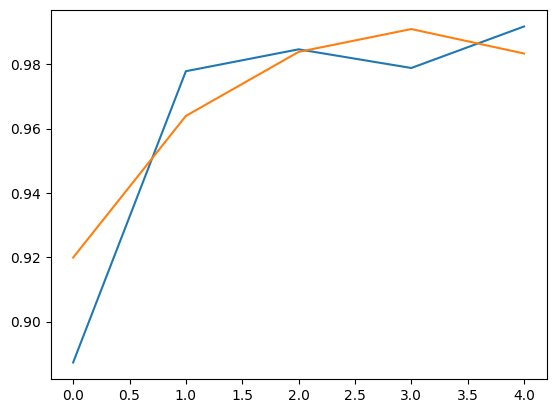

In [16]:
d1 = { 'F1_B': 0.9199, 'F1_I': 0.9975, 'F1_O': 0.9343, 'Precision_B': 0.9199, 'Precision_I': 0.9975, 'Precision_O': 0.9343, 'Recall_B': 0.9199, 'Recall_I': 0.9975, 'Recall_O': 0.9343, 'DSC': 1.0}
d2 = { 'F1_B': 0.9639, 'F1_I': 0.9992, 'F1_O': 0.9265, 'Precision_B': 0.9639, 'Precision_I': 0.9992, 'Precision_O': 0.9265, 'Recall_B': 0.9639, 'Recall_I': 0.9992, 'Recall_O': 0.9265, 'DSC': 1.0}
d3 = { 'F1_B': 0.9838, 'F1_I': 0.9987, 'F1_O': 0.9186, 'Precision_B': 0.9838, 'Precision_I': 0.9987, 'Precision_O': 0.9186, 'Recall_B': 0.9838, 'Recall_I': 0.9987, 'Recall_O': 0.9186, 'DSC': 1.0}
d4 = { 'F1_B': 0.9909, 'F1_I': 0.9987, 'F1_O': 0.9224, 'Precision_B': 0.9909, 'Precision_I': 0.9987, 'Precision_O': 0.9224, 'Recall_B': 0.9909, 'Recall_I': 0.9987, 'Recall_O': 0.9224, 'DSC': 1.0}
d5 = { 'F1_B': 0.9833, 'F1_I': 0.9964, 'F1_O': 0.9244, 'Precision_B': 0.9833, 'Precision_I': 0.9964, 'Precision_O': 0.9244, 'Recall_B': 0.9833, 'Recall_I': 0.9964, 'Recall_O': 0.9244, 'DSC': 1.0}
dl = [d1,d2,d3,d4,d5]
keys = list(d1.keys())
df2 = {key:[] for key in keys}
for i in range(5):
    for k in keys:
        df2[k].append(dl[i][k])
        
df2 = pd.DataFrame(df2)



df['F1_B'].plot()
df2['F1_B'].plot()


<AxesSubplot: >

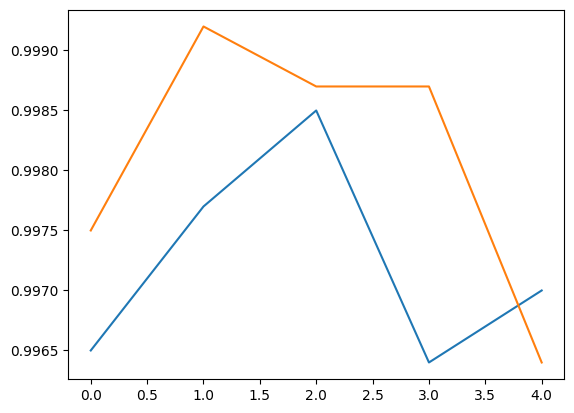

In [17]:
df['F1_I'].plot()
df2['F1_I'].plot()

<AxesSubplot: >

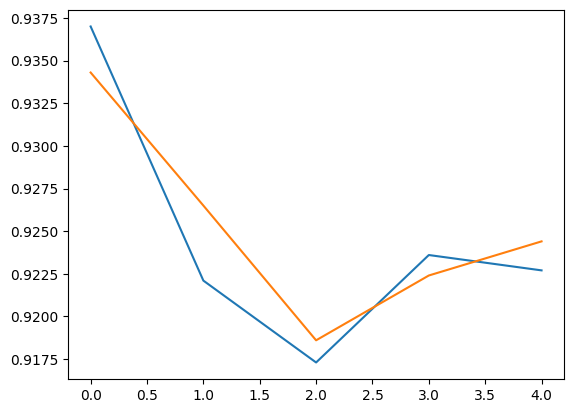

In [20]:
df['F1_O'].plot()
df2['F1_O'].plot()